In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

datasheet = '/content/drive/My Drive/Datasheet/DDoS/dataset_sdn.csv'

df = pd.read_csv(datasheet)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
print("Jumlah Missing Values")
print(df.isnull().sum())

Jumlah Missing Values
dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64


**PREPROCESSING**

In [3]:
df = df.dropna(subset=['rx_kbps','tot_kbps'])
df['label'] = df['label'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103839 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           103839 non-null  int64  
 1   switch       103839 non-null  int64  
 2   src          103839 non-null  object 
 3   dst          103839 non-null  object 
 4   pktcount     103839 non-null  int64  
 5   bytecount    103839 non-null  int64  
 6   dur          103839 non-null  int64  
 7   dur_nsec     103839 non-null  int64  
 8   tot_dur      103839 non-null  float64
 9   flows        103839 non-null  int64  
 10  packetins    103839 non-null  int64  
 11  pktperflow   103839 non-null  int64  
 12  byteperflow  103839 non-null  int64  
 13  pktrate      103839 non-null  int64  
 14  Pairflow     103839 non-null  int64  
 15  Protocol     103839 non-null  object 
 16  port_no      103839 non-null  int64  
 17  tx_bytes     103839 non-null  int64  
 18  rx_bytes     103839 non-null 

In [4]:
Features = [
    'dt','dur','dur_nsec','tot_dur','pktrate','Protocol','port_no','tx_kbps','rx_kbps','tot_kbps'
]
df_fitur = df[Features]

In [5]:
from sklearn.model_selection import train_test_split

X = df_fitur
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=42, stratify=y
)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,y_train, test_size = 0.2, random_state=42, stratify=y_train
)

In [9]:
numeric_features = ['dt','dur','dur_nsec','tot_dur','pktrate','port_no','tx_kbps','rx_kbps','tot_kbps']
categorial_features = ['Protocol']

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
num_feat = numeric_features
num_tranform = scaler

In [11]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_feat = categorial_features
cat_transform = encoder

In [12]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transform, cat_feat),
        ('num', num_tranform, num_feat)
    ],
    remainder = 'drop'
)

In [17]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.fit_transform(X_test)
X_val_prep = preprocessor.fit_transform(X_val)

In [18]:
input_dim = X_train_prep.shape[1]

**BUILD MODEL**

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers

num_classes = len(np.unique(y_train))
model = keras.Sequential([
    #Layer 1
    layers.Dense(units=112, activation='relu', input_shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dropout(0.0), #No Dropout

    #Layer 2
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),

    #Layer 3
    layers.Dense(units=64, activation='tanh'),
    layers.BatchNormalization(),
    layers.Dropout(0.0),

    #Output Layers
    layers.Dense(units=num_classes, activation='softmax')
])

learning_rate = 0.0009739768003064985

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**TRAINING MODEL**

In [20]:
history = model.fit(
    X_train_prep, y_train,
    validation_split = 0.2,
    epochs = 50,
    validation_data = (X_val_prep, y_val),
    verbose = 1
)

Epoch 1/50
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8501 - loss: 0.3345 - val_accuracy: 0.9274 - val_loss: 0.1689
Epoch 2/50
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9172 - loss: 0.1920 - val_accuracy: 0.9290 - val_loss: 0.1564
Epoch 3/50
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9281 - loss: 0.1687 - val_accuracy: 0.9376 - val_loss: 0.1403
Epoch 4/50
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9317 - loss: 0.1602 - val_accuracy: 0.9425 - val_loss: 0.1319
Epoch 5/50
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9370 - loss: 0.1498 - val_accuracy: 0.9422 - val_loss: 0.1352
Epoch 6/50
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9419 - loss: 0.1403 - val_accuracy: 0.9494 - val_loss: 0.1171
Epoch 7/50
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9440 - loss: 0.1316 - val_accuracy: 0.9542 - val_loss: 0.1044
Epoch 8/50
2077/2077 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9469 - loss: 0.1307 

**EVALUATE MODEL**

In [21]:
test_loss, test_acc = model.evaluate(X_test_prep, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f} | Test acc :{test_acc:.4f}")

Test loss: 0.0526 | Test acc :0.9801


In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = np.argmax(model.predict(X_test_prep), axis = 1)
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi model dengan data pengujian : {acc:.4f}")

649/649 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Akurasi model dengan data pengujian : 0.9801


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     12667
           1       0.98      0.97      0.97      8101

    accuracy                           0.98     20768
   macro avg       0.98      0.98      0.98     20768
weighted avg       0.98      0.98      0.98     20768



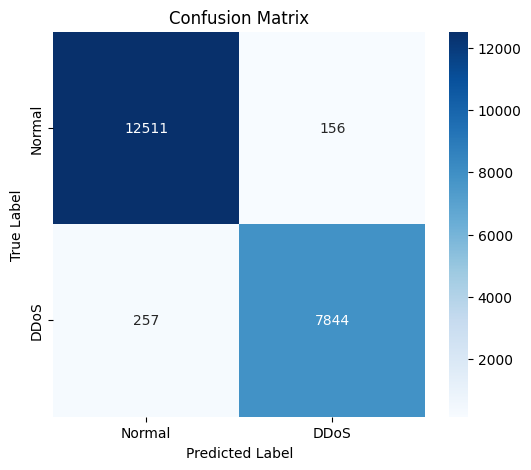

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

label = ['Normal','DDoS']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label,
            yticklabels=label)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [29]:
model.save("MLP_Detection_DDoS.keras")

In [30]:
from google.colab import files

files.download('MLP_Detection_DDoS.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>